# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Nemish Murawat*

**Matricola**: *2056142*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

2024-07-09 10:34:49.657482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 10:34:49.657590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 10:34:49.788654: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

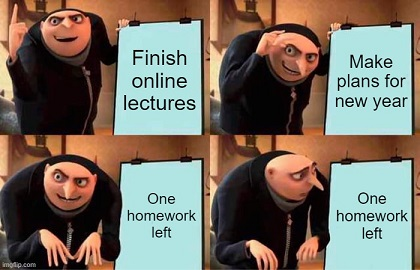

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

## ✍ **DATASET DESCRIPTION**

> ### I would be using Dair-AI emotion dataset which is made up of english tweets extracted from the twitter. Based on the hashtags in the tweets with some preprocessing the labels were assigned to the tweets. Further *sadness,joy,anger,love,fear,suprise* are the possible emotions aka classes. The following dataset was used in the follwoing paper [CARER:Contextualized Affect Representations for Emotion Recognition](https://aclanthology.org/D18-1404/) which focussed on non-transformer based models to extract contextualised features. The dataset contains about 20K samples and the three splits of 80/10/10 i.e. train/val/test are present. 
> ### In the cells below one can find basic statistics derived from the datasets.
> ### 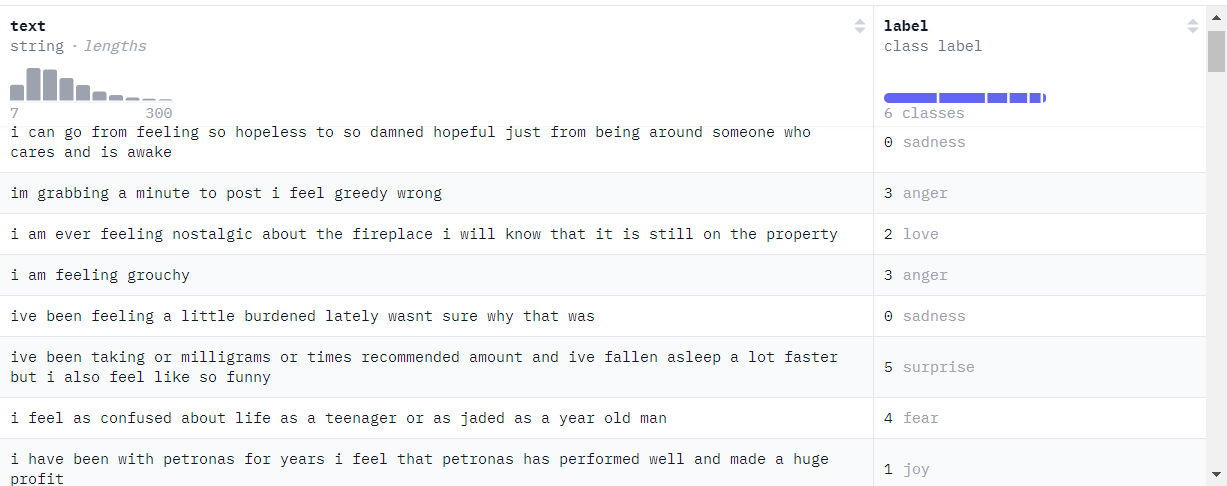<figcaption style="text-align: center;">Snapshot of the dataset</figcaption>


In [3]:

try:
    from datasets import load_dataset
except:
    !pip install datasets
    from datasets import load_dataset
######## Get the dataset
dataset = load_dataset("dair-ai/emotion", "split")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Statistics of Data Splits

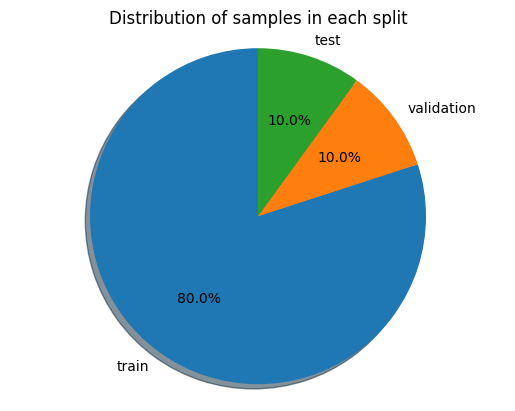

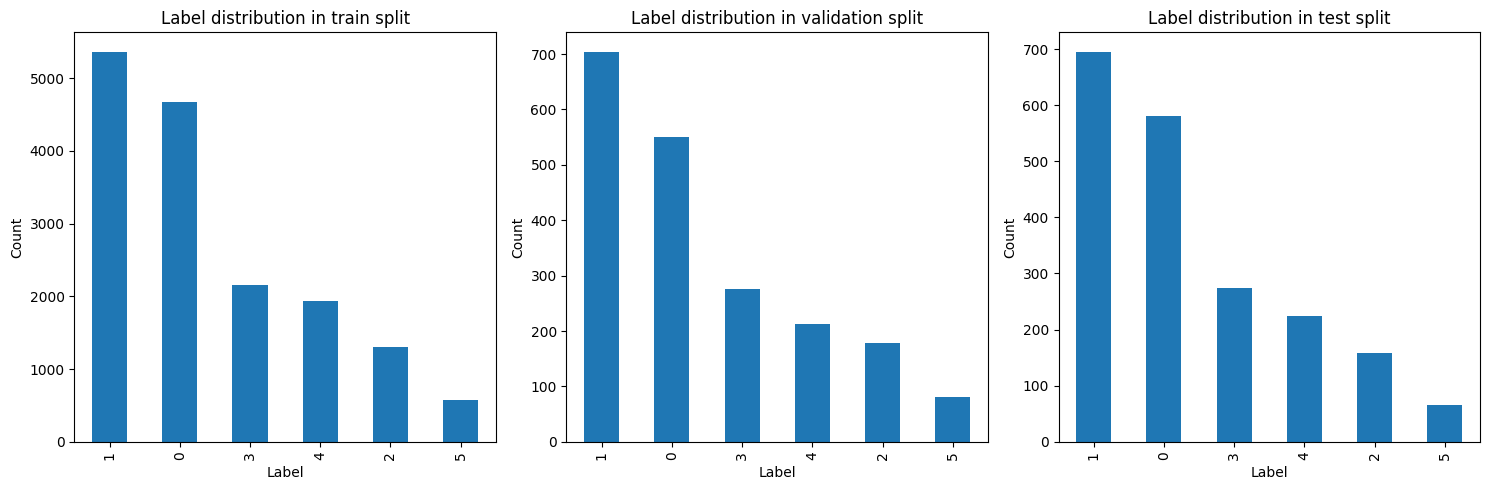

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
# Get the number of samples in each split
num_samples = {split: len(dataset[split]) for split in dataset.keys()}

# Create a pie chart to show the percentage of samples in each split
labels = list(num_samples.keys())
sizes = list(num_samples.values())
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures a circular pie chart
plt.title('Distribution of samples in each split')
plt.show()

# Get the distribution of labels in each split
label_distribution = {}
for split in dataset.keys():
  labels = [data["label"] for data in dataset[split]]
  label_distribution[split] = pd.Series(labels).value_counts()

# Plot the distribution of labels in each split
fig2, axes = plt.subplots(nrows=1, ncols=len(dataset.keys()), figsize=(15, 5))
for i, split in enumerate(dataset.keys()):
  label_distribution[split].plot(kind="bar", ax=axes[i])
  axes[i].set_title(f"Label distribution in {split} split")
  axes[i].set_xlabel("Label")
  axes[i].set_ylabel("Count")
plt.tight_layout()
plt.show()


### Convert to tensorflow datasets

In [5]:
#### Train,Validation and Test split
train_dataset = dataset["train"].to_tf_dataset(
    columns=["text", "label"],
    batch_size=64,
    shuffle=True,
)

validation_dataset = dataset["validation"].to_tf_dataset(
    columns=["text", "label"],
    batch_size=64,
    shuffle=False,
)

test_dataset = dataset["test"].to_tf_dataset(
    columns=["text", "label"],
    batch_size=64,
    shuffle=False,
)

In [6]:
# Get the number of classes in the training dataset
num_classes = len(set(data["label"] for data in dataset["train"]))

print(f"Number of classes: {num_classes}")

Number of classes: 6


### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

## PEFT:LORA:

> ### I would be using LORA to perform parameter efficient fine tuning.
> ### My base model would be DistilBert Base which is a small, fast, cheap and light Transformer model trained by distilling BERT base.My aim is to utilise the pre-trained powerful general-purpose language representation present in the model and fine-tune for my specifc task aka emotion detection.
> ### I would be adding lora weights to the following layer: 
>> ### Query and Value kernel in the self-attention layer. This is motivated by the paper [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647)
>> ### Feedforward Dense layers(Up-scale and Down-Scale) in the transformer block
> ### Implementation of LORA is highly motivated from the official tutorial in Keras documentation [LORA in GPT-2](https://keras.io/examples/nlp/parameter_efficient_finetuning_of_gpt2_with_lora/)

In [7]:

try:
  import keras_nlp
except:
  !pip install keras-nlp
  import keras_nlp


from tensorflow import keras
from keras import layers


### Preprocessing:
> #### Tokenisation:
>> #### Usage of DistilBert PreProcessor which performs two main task:
>> #### 1. tokenise the text
>> #### 2. map tokens to vocab index i.e input_ids and attention mask(distinguishes between real and padding tokens)


In [8]:
### Load the proceprocessor

preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en")


### see the default arguments values
print(preprocessor.get_config())


def pre_process(text,label):
  ### class number to one hot vecotr
  one_hot_vector = tf.one_hot(label, num_classes)
  return (preprocessor(text),one_hot_vector)


Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'preprocessor.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.txt' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...


{'name': 'distil_bert_preprocessor', 'trainable': True, 'dtype': 'float32', 'tokenizer': {'module': 'keras_nlp.src.models.distil_bert.distil_bert_tokenizer', 'class_name': 'DistilBertTokenizer', 'config': {'name': 'distil_bert_tokenizer', 'trainable': True, 'dtype': 'int32', 'vocabulary': None, 'sequence_length': None, 'lowercase': False, 'strip_accents': False, 'split': True, 'suffix_indicator': '##', 'oov_token': '[UNK]'}, 'registered_name': 'keras_nlp>DistilBertTokenizer'}, 'sequence_length': 512, 'truncate': 'round_robin'}


In [9]:
#### applying preprocessing to the raw text for train/val/test set
train_dataset=train_dataset.map(lambda x: pre_process(x['text'],x['label']))
validation_dataset=validation_dataset.map(lambda x:pre_process(x['text'],x['label']))
test_dataset=test_dataset.map(lambda x:pre_process(x['text'],x['label']))


## Loss Fn,Metrics and Optimizer

In [31]:
### Optimier
lr=5e-4
opt=keras.optimizers.Adam(learning_rate=lr,weight_decay=1e-5)
### Loss function on logits
loss_fn=keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction="sum_over_batch_size",
    name="categorical_crossentropy",
)
### metrics to track
METRICS = [

      keras.metrics.F1Score(average='micro',name='f1_score'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc',from_logits=True),
      
]

###Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)


## Define base model

> #### Here I utilise the Keras_nlp DistilBert(model type:Base-EN) Classifier module which consists of bert-backbone and linear layer for mapping bert[cls] vector to class logits

In [36]:

###Distilbert base_model_en
classifier = keras_nlp.models.Classifier.from_preset(
    "distil_bert_base_en",
    num_classes=num_classes,preprocessor=None,load_weights=True)

### Freeze the backbone
classifier.backbone.trainable = False
### get classifier summary
classifier.summary()

Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'task.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'metadata.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/distil_bert/keras/distil_bert_base_en/2' to your Kaggle notebook...

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      65,190,912 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 6)                 │           4,614 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 65,786,118 (250.95 MB)

 Trainable params: 595,206 (2.27 MB)

 Non-trainable params: 65,190,912 (248.68 MB)

### Note: We can see after freezing the backbone, only Pooled_dense and classification(i.e logits) are trainable.

## LoRA layer

In [37]:
import math
class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=8,
        trainable=False,
        mode_lora:str='query_value',
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        # print(original_layer,original_layer.get_config())
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)
        
        
        #### rank of decomposition matrics
        self.rank = rank

        self.alpha = alpha
        ##### scaling factor
        self._scale = alpha / rank
        
        
        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False
        
        if mode_lora=='query_value':
            ### Number of heads
            self._num_heads = original_layer_config['output_shape'][-2]
            ### Hidden dimension==> Num_of_heads*each_head_output_dim
            self._hidden_dim = self._num_heads * original_layer_config['output_shape'][-2]
            
            
            # LoRA dense layers.
            self.A = keras.layers.Dense(
                units=rank,
                use_bias=False,
                # the official LoRA implementation
                # uses "Kaiming/He Initialization".
                kernel_initializer=keras.initializers.VarianceScaling(
                    scale=math.sqrt(5), mode="fan_in", distribution="uniform"
                ),
                trainable=trainable,
                name=f"lora_A",
            )
            #### This information is present in the config of each layer
            # B has the same `equation` and `output_shape` as the original layer.
            # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
            # length, `c`: `hidden_dim`, `d`: `num_heads`,
            # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
            # `c` represents `rank`.
            ### B is intialise zero as we want the the model to give the same output as the original model initally
            self.B = keras.layers.EinsumDense(
                equation=original_layer_config["equation"],
                output_shape=original_layer_config["output_shape"],
                kernel_initializer="zeros",
                trainable=trainable,
                name=f"lora_B",
            )
        elif mode_lora=='inter_out':
            # LoRA-A
            self.A = keras.layers.Dense(
                units=rank,
                use_bias=False,
                # the official LoRA implementation
                # uses "Kaiming/He Initialization".
                kernel_initializer=keras.initializers.VarianceScaling(
                    scale=math.sqrt(5), mode="fan_in", distribution="uniform"
                ),
                trainable=trainable,
                name=f"lora_A",
            )
            
            # LoRA-B
            self.B = keras.layers.Dense(
                units=original_layer_config['units'],
                use_bias=False,
                kernel_initializer='zeros',
                trainable=trainable,
                name=f"lora_B",
            )
        

        

        ### build the weights==> We know the input shape would be [Batch_size,Sequence_length,hidden_dim] for attention or [Batch_size*Sequence_length,hidden_dim] for feed_forward
        input_shape=original_layer.get_build_config()['input_shape']
        self.build_weights(input_shape)
        
    
    def build_weights(self, input_shape):
        # This ensures that the LoRA layers are properly built i.e weight intialisatation
        self.A.build(input_shape)
        self.B.build(self.A.compute_output_shape(input_shape))
     

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        return original_output

### ADD LORA LAYERS TO MODEL

In [38]:
# #### initiate the lora model:
def add_lora_layers_self_att(lora_model,num_layers:int,RANK:int,ALPHA:int,mode:str):
    
    #### possible_places_of_addition
    
    change_map={'all':['query_value','inter_out'],'att_only':['query_value']}
    
    try:
        add_loc=change_map[mode]
    except:
        raise ValueError('Mode can be wither all or att_only')
    
    for layer_idx in range(classifier.backbone.num_layers):
         if layer_idx>= classifier.backbone.num_layers-num_layers:
            
            ### get the ith transformer layer
            encoder_layer = classifier.backbone.get_layer(f"transformer_layer_{layer_idx}")
            
            
            # print(classifier.backbone.get_layer(f'transformer_layer_{layer_idx}')._self_attention_layer._query_dense.get_config())
            
            for i in add_loc:
                #### ADd lora layer for W_Q and W_V
                if i=='query_value':

                    self_attention_layer = encoder_layer._self_attention_layer
                    # Allow mutation to Keras layer state.
                    self_attention_layer._tracker.locked = False

                    # Change query dense layer.
                    self_attention_layer._query_dense = LoraLayer(
                        self_attention_layer._query_dense,
                        rank=RANK,
                        alpha=ALPHA,
                        trainable=True,mode_lora=i
                    )

                    # Change value dense layer.
                    self_attention_layer._value_dense = LoraLayer(
                        self_attention_layer._value_dense,
                        rank=RANK,
                        alpha=ALPHA,
                        trainable=True,mode_lora=i
                    )
                ### ADD lora layer to FFN in transformer block
                elif i=='inter_out':
                   
                    encoder_layer._tracker.locked = False
                    
                    # Change intermediate dense layer
                    encoder_layer._feedforward_intermediate_dense = LoraLayer(
                        encoder_layer._feedforward_intermediate_dense,
                        rank=RANK,
                        alpha=ALPHA,
                        trainable=True,
                        mode_lora=i
                    )
                    
                    # Change output dense layer
                    encoder_layer._feedforward_output_dense = LoraLayer(
                        encoder_layer._feedforward_output_dense,
                        rank=RANK,
                        alpha=ALPHA,
                        trainable=True,
                        mode_lora=i
                    )
                    
                    
#### Add lora layers
rank=8
alpha=8
### num_layers==> how many last num_layers to add LORA weight matrices
num_layers=3 
add_lora_layers_self_att(classifier,num_layers,rank,alpha,'all')


### Freezing all the non-lora layer in the Backbone of the classifier

In [39]:
#### Freezing all the non-lora layers in backbone
for layer in classifier.backbone._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())
    # print(lst_of_sublayers)
    if len(lst_of_sublayers) == 1:  # "leaves of the model"
       
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
           
        else:
            layer.trainable = False
print(classifier.summary())

Model: "distil_bert_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      65,448,960 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 6)                 │           4,614 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,044,166 (251.94 MB)

 Trainable params: 853,254 (3.25 MB)

 Non-trainable params: 65,190,912 (248.68 MB)

None


### Perform LORA fine-tuning

In [15]:
classifier.compile(optimizer=opt,loss=loss_fn,metrics=METRICS)
epochs=20
evaluate_results=classifier.evaluate(validation_dataset)
history = classifier.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,callbacks=[early_stopping])

I0000 00:00:1720521353.808934     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.1814 - auc: 0.4970 - f1_score: 0.1814 - loss: 1.7984

W0000 00:00:1720521388.144647     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.1816 - auc: 0.4967 - f1_score: 0.1816 - loss: 1.7985
Epoch 1/20


W0000 00:00:1720521441.850738     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


250/250 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - accuracy: 0.5937 - auc: 0.8580 - f1_score: 0.5937 - loss: 1.0672 - val_accuracy: 0.8660 - val_auc: 0.9730 - val_f1_score: 0.8660 - val_loss: 0.3923
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.8416 - auc: 0.9700 - f1_score: 0.8416 - loss: 0.4363 - val_accuracy: 0.9075 - val_auc: 0.9859 - val_f1_score: 0.9075 - val_loss: 0.2482
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.8847 - auc: 0.9816 - f1_score: 0.8847 - loss: 0.3168 - val_accuracy: 0.9210 - val_auc: 0.9905 - val_f1_score: 0.9210 - val_loss: 0.2105
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.8970 - auc: 0.9870 - f1_score: 0.8970 - loss: 0.2575 - val_accuracy: 0.9190 - val_auc: 0.9925 - val_f1_score: 0.9190 - val_loss: 0.1929
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9151 - auc: 0.9901 - f1_score: 0.9151 - loss: 0.2150 - val_accuracy: 0.9205 - val_auc: 0.9921 - val_f1_score: 0.9205 - val_loss: 0.1

In [40]:
# classifier.save_weights('./trained_1.weights.h5')
# classifier.load_weights('./trained_1.weights.h5')

## Merge LORA Weights :
> ### Once the optmised Lora weights are computed I would merge them back into the original layers to get the new model having same number of parameters as before and fine-tuned for my current task.

In [41]:
# #### merge th lora weights to the original weight
def merge_lora_layers_self_att(lora_model,num_layers:int,RANK,ALPHA,mode:str):
    
    #### possible_places_of_merging
    
    merge_map={'all':['query_value','inter_out'],'att_only':['query_value']}
    
    try:
        merge_loc=merge_map[mode]
    except:
        raise ValueError('Mode can be either all or att_only')
    
    for layer_idx in range(classifier.backbone.num_layers):
         if layer_idx>= classifier.backbone.num_layers-num_layers:
#             print(layer_idx)
          
            ### get the ith transformer layer
            encoder_layer = classifier.backbone.get_layer(f"transformer_layer_{layer_idx}")
            
            
            # print(classifier.backbone.get_layer(f'transformer_layer_{layer_idx}')._self_attention_layer._query_dense.get_config())
            
            for i in merge_loc:
                #### merge lora layer for W_Q and W_V
                if i=='query_value':

                    self_attention_layer = encoder_layer._self_attention_layer
                    
                   # Merge query dense layer.
                    query_lora_layer = self_attention_layer._query_dense

                    A_weights = query_lora_layer.A.kernel  # (seq_length, rank)
                    B_weights = query_lora_layer.B.kernel  # (rank, num_heads, per_head_dim)
                    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
                    query_lora_layer.original_layer.kernel.assign_add(increment_weights)

                    # Merge value dense layer.
                    value_lora_layer = self_attention_layer._value_dense

                    A_weights = value_lora_layer.A.kernel  # (seq_length, rank)
                    B_weights = value_lora_layer.B.kernel  # (rank, num_heads, per_head_dim)
                    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
                    value_lora_layer.original_layer.kernel.assign_add(increment_weights)

                    # Put back in place the original layers with updated weights
                    self_attention_layer._query_dense = query_lora_layer.original_layer
                    self_attention_layer._value_dense = value_lora_layer.original_layer
                    
                    
                    
                elif i=='inter_out':
                    
                    
                    # Merge Feedforward intermediate dense layer.
                    ffn_inter_lora_layer = encoder_layer._feedforward_intermediate_dense

                    A_weights = ffn_inter_lora_layer.A.kernel  # (768, rank) 
                    B_weights = ffn_inter_lora_layer.B.kernel  # (rank, 3072) 
                    increment_weights =  tf.einsum("ab,bc->ac", A_weights, B_weights) * (ALPHA / RANK)
                    ffn_inter_lora_layer.original_layer.kernel.assign_add(increment_weights)
                    # Put back in place the original layers with updated weights
                    encoder_layer._feedforward_intermediate_dense = ffn_inter_lora_layer.original_layer
                  
                    # Merge Feedforward output dense layer.
                    ffn_out_lora_layer = encoder_layer._feedforward_output_dense

                    A_weights = ffn_out_lora_layer.A.kernel  # (3072, rank) 
                    B_weights = ffn_out_lora_layer.B.kernel  # (rank, 768) 
                    increment_weights =  tf.einsum("ab,bc->ac", A_weights, B_weights) * (ALPHA / RANK)
                    ffn_out_lora_layer.original_layer.kernel.assign_add(increment_weights)
                    # Put back in place the original layers with updated weights
                    encoder_layer._feedforward_output_dense = ffn_out_lora_layer.original_layer
                    
rank=8
alpha=8
num_layers=3                   
#### merge lora layers
merge_lora_layers_self_att(classifier,num_layers,rank,alpha,'all')


## Final Results

### Traning and Validation Loss and Metrics Curves

> ### We can clearly see from the plots that the model is able to achieve good generalisation performance within few epochs. At the end,15th epoch turned out to be best based on Validation AUC with Training Accuracy and validation accuracy being  94%,92.7% represctively.

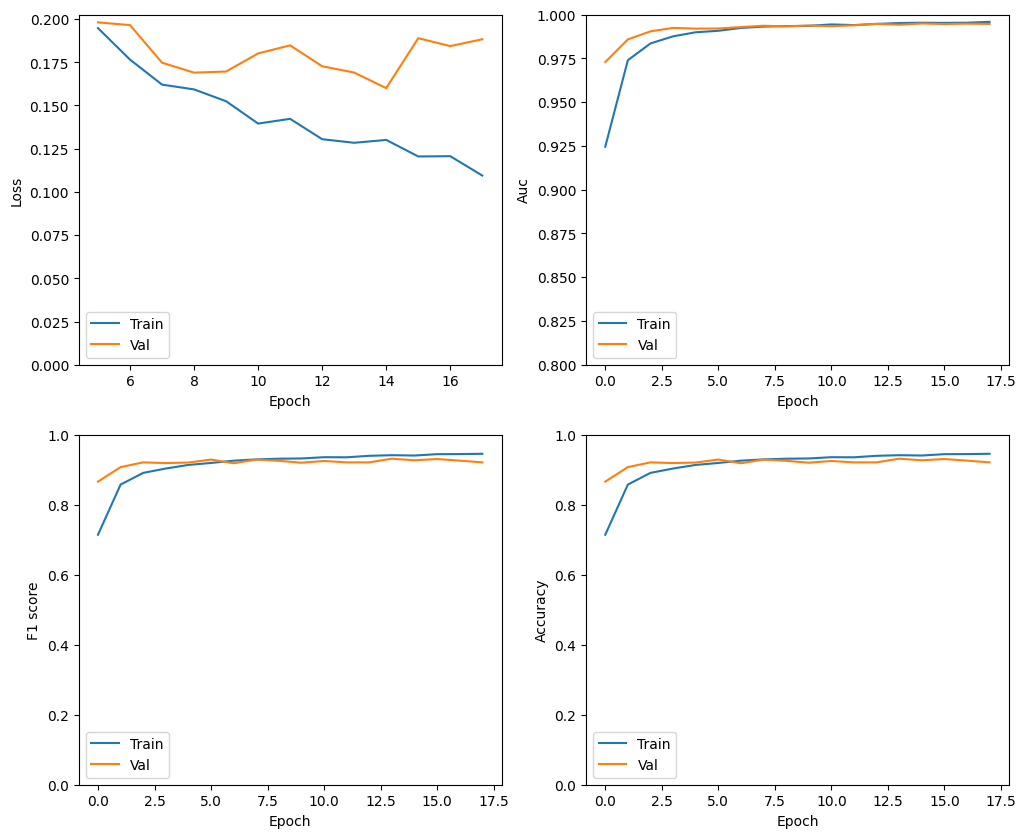

In [21]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'auc', 'f1_score','accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    if metric=='loss':
        plt.plot(history.epoch[5:], history.history[metric][5:], color=colors[0], label='Train')
        plt.plot(history.epoch[5:], history.history['val_'+metric][5:],
             color=colors[1], label='Val')

    else:
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')

        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
#   plt.title('Metrics')
plot_metrics(history)

### Test Set Results

In [43]:
classifier.compile(optimizer=opt,loss=loss_fn,metrics=METRICS)
results_test=classifier.evaluate(test_dataset)


31/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9130 - auc: 0.9925 - f1_score: 0.9130 - loss: 0.1924

W0000 00:00:1720530654.946307     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9130 - auc: 0.9926 - f1_score: 0.9130 - loss: 0.1923


In [45]:
import numpy as np
from sklearn.metrics import classification_report
def generate_classification_report(classifier, test_dataset):

    
    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_true_labels = []
    
    # Iterate over the batches
    for x_batch, y_batch  in test_dataset:

        
        # Get predictions for this batch
        batch_predictions = classifier.predict(x_batch)
    
        
        batch_predictions = np.argmax(batch_predictions, axis=-1)
        
        # Append batch predictions and true labels
        all_predictions.extend(batch_predictions)
        all_true_labels.extend(np.argmax(y_batch,axis=-1)) ### Due to one hot vector===> Label
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)
    
    # Generate and print the classification report
    report = classification_report(all_true_labels, all_predictions)
    print("Classification Report:")
    print(report)
    
generate_classification_report(classifier, test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

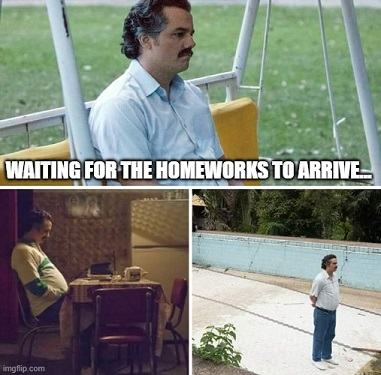